<h1>Speech Language Identification</h1>

The method involves using Spectogram to analyse the spacial temporal data of the sound sample with the help of Librosa to generate images of the Spectogram graph and saving them. CNNs were used after the graphs were generated in the form of the images to study the patterns to classify the languages in the following categories of German, English and Spanish.

In [1]:
import librosa
import librosa.display
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time

<h3>Generating the spectrogram for the audio sample</h3>

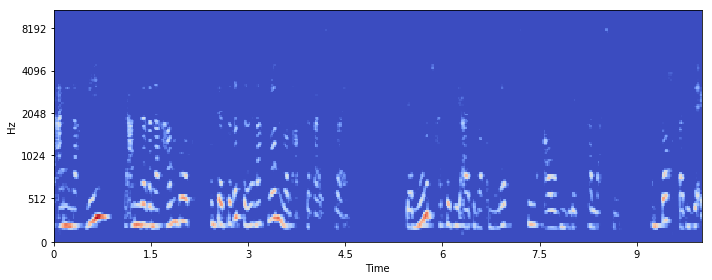

In [7]:
index = 100
files = os.listdir('dataset/test')
y, sr = librosa.load("dataset/test/" + files[index])
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.amplitude_to_db(S)
plt.figure(figsize=(10,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.tight_layout()

In [46]:
def save_spectrogram_image(name, path = 'dataset/train_spectrogram_images/'):
    y, sr = librosa.load("dataset/test/" + name)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S)
    plt.figure(figsize=(6,6))
    librosa.display.specshow(log_S, sr=sr)
    plt.savefig(path + name + '.png')

In [80]:
def move_image_directory(name, folder):
    source = 'dataset/train_spectrogram_images/' + name + '.png'
    destination = 'dataset/train_spectrogram_images/' + folder + '/' + name + '.png'
    try:
        shutil.move(source, destination)
    except:
        os.mkdir('dataset/train_spectrogram_images/' + folder)
        shutil.move(source, destination)
def sort_spectrogram_image(name):
    language = name[:2]
    move_image_directory(name, language)

In [ ]:
for i in files:
    save_spectrogram_image(i)

In [82]:
for i in files:
    sort_spectrogram_image(i)

<h3>Creating the batches for the dataset</h3>

In [2]:
def load_dataset():
    data_path_train = 'dataset/train_spectrogram_images'
    data_path_test = 'dataset/test_spectrogram_images'
    dataset_train = torchvision.datasets.ImageFolder(
        root=data_path_train,
        transform=torchvision.transforms.ToTensor()
    )
    dataset_test = torchvision.datasets.ImageFolder(
        root=data_path_test,
        transform=torchvision.transforms.ToTensor()
    )
    test_loader = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=16,
        num_workers=0,
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=16,
        num_workers=0,
        shuffle=True
    )
    return train_loader, test_loader, dataset_test

In [10]:
epochs = 1

<h3>Defining the CNN architecture</h3>

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.fc1 = nn.Linear(54*54*128, 1000)
        self.fc2 = nn.Linear(1000, 3)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

<h3>Training the model</h3>

In [4]:
device_training = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader, dataset = load_dataset()
model = CNNModel().to(device_training)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loss_history = []
accuracy_history = []
batches = len(train_loader)

performance = [0]

for j in range(0, epochs):
    
    # Calculating the train accuracy of the model for each batch
    correct_train, total_train, error_train = 0, 0, 0
    for i, (images, labels) in enumerate(train_loader):
        # Calculating the output, error
        outputs = model(images)
        error = loss(outputs, labels)
        loss_history.append(error.item())
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy_history.append(correct / total)
        
        correct_train += correct
        error_train += error
        total_train += total
        # Logging the performance of the model after each batch
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(j + 1, epochs, i + 1, batches, error.item(), (correct / total) * 100))
    
    # Calculating the test accuracy of the model
    correct_test, total_test, error_test = 0, 0, 0
    for i, (images_test, labels_test) in enumerate(test_loader):
        outputs_test = model(images_test)
        error_test = loss(outputs_test, labels_test)
        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        error_test += error_test
        
    test_accuracy = (correct_test / total_test) * 100
    named_tuple = time.localtime() # get struct_time
    time_string = time.strftime("%m:%d:%Y-%H:%M:%S", named_tuple)  
    performance.append(test_accuracy)

    flag = True
    for i in performance:
        if test_accuracy < i:
            flag = False
    if flag == True:
        torch.save(model.state_dict(), 'CNNModel-{}-{:.2f}.pth'.format(time_string, test_accuracy))
        print("Saved the updated model")  
        
    print('Test Error of the model on the test images: {} %'.format((error_test / total_test)))
    print('Test Accuracy of the model on the test images: {} %'.format(test_accuracy))
    print('Train Error of the model on the test images: {} %'.format((error_train / total_train)))
    print('Train Accuracy of the model on the test images: {} %'.format((correct_train / total_train) * 100))

<h3>Loading the trained model on the Google Colab</h3>

In [223]:
device = torch.device('cpu')
model = CNNModel()
model = torch.load("./models/CNNModel-05_21_2019-13_02_46-99.17.pth", map_location=device)

In [224]:
# Calculating the test accuracy of the model
correct_test, total_test, error_test = 0, 0, 0
for i, (images_test, labels_test) in enumerate(test_loader):
    images_test = images_test
    outputs_test = model(images_test)
    error_test = loss(outputs_test, labels_test)
    _, predicted_test = torch.max(outputs_test.data, 1)
    total_test += labels_test.size(0)
    correct_test += (predicted_test == labels_test).sum().item()
    error_test += error_test
    
test_accuracy = (correct_test / total_test) * 100
print(test_accuracy)

99.16666666666667


In [301]:
image_number = 40
input_in_the_model = np.reshape(dataset[image_number][0], (1, 3, 432, 432))
prediction_from_dataset = model(input_in_the_model)
print(prediction_from_dataset)

tensor([[ 61.7775,  59.7987, -84.9253]], grad_fn=<AddmmBackward>)


<h3>Predictions</h3>

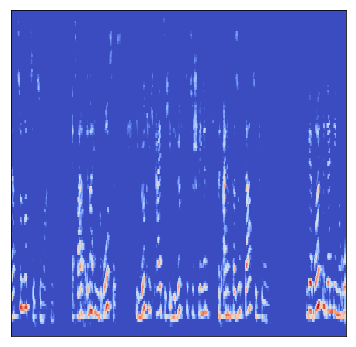

In [399]:
name_of_the_track = "de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment70" # From the test folder add the name of the audio clip
save_spectrogram_image(name_of_the_track + ".flac", "./dataset/predict/general/")

In [400]:
datapath_predict = './dataset/predict/'
predict_dataset = torchvision.datasets.ImageFolder(
    root=datapath_predict,
    transform=torchvision.transforms.ToTensor()
)

list_of_images_in_prediction_folder = os.listdir(datapath_predict + 'general')
languages = ['German', 'English', 'Spanish']
flag = 0

for i in list_of_images_in_prediction_folder:
    if i == name_of_the_track + '.flac.png':
        input_in_the_model = np.reshape(predict_dataset[0][0], (1, 3, 432, 432))
        outputs_from_model = model(input_in_the_model)
        prediction = outputs_from_model.argmax()
        print("Detected {} Language".format(languages[prediction]))
        break
    flag = flag + 1

Detected German Language
